In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import wgangp_encoder.model as modelsrc
import imp
from main_dataset import SingleCropGenerator
from image_set import ImageSet
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
imp.reload(modelsrc)

<module 'wgangp_encoder.model' from '/home/pmistry9597/Climate-Hack-2022/wgangp_encoder/model.py'>

Setup dataset and dataloader

In [4]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
# dataset = CHMainDataset(np_set, gen)
dataset = ImageSet(np_set, gen)

In [7]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = modelsrc.Encoder()
        self.decoder = modelsrc.Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
ae = AE()
garbo = torch.randn([1, 1, 128, 128])
ae(garbo).shape

torch.Size([1, 1, 128, 128])

Training Setup

In [10]:
BATCH_LEN = 16 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [6]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

NameError: name 'dataset' is not defined

In [6]:
model = ModelToTest()

Training utilities
# wow

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

NameError: name 'model' is not defined

Training loop definition

In [11]:
dir_to_save = 'attnconv_ae'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [22]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch):
    its_til_checkpoint = 20
    its_til_update = 1
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    for i, (features, targets) in enumerate(dataloader):
        features = features.view([-1, 1, 128, 128]).to(device)
        targets = targets.to(device)

        predictions = model(features)
        
#         print(predictions.shape, targets.shape)
        loss = criterion(predictions, targets.unsqueeze(1))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
            
        if i == 360: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [21]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'cl_loader' is not defined

In [20]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch)
        print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
        plt.plot(epoch_losses, 'r-')
        plt.title('Epoch Losses')
        plt.show()
    
    return losses

In [14]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = ImageSet(np_set, gen)
dataset[0][1].shape

(128, 128)

In [23]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = AE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
msssim = MS_SSIMLoss(channels=1)
l1 = torch.nn.L1Loss()
mse = torch.nn.MSELoss()
criterion = lambda pred, target: msssim(pred,target) #msssim(pred,target) #+ l1(pred,target) 

Entering epoch 0
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

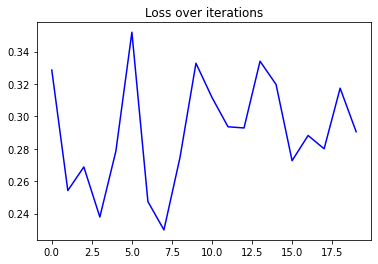

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

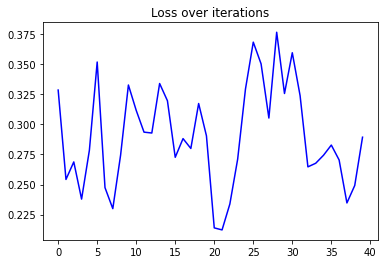

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

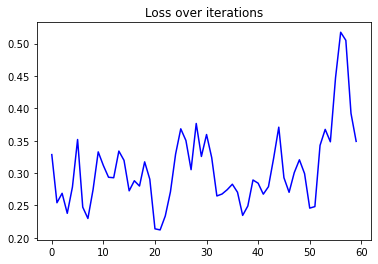

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

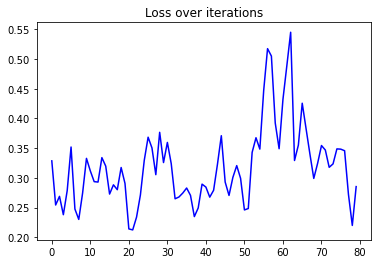

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

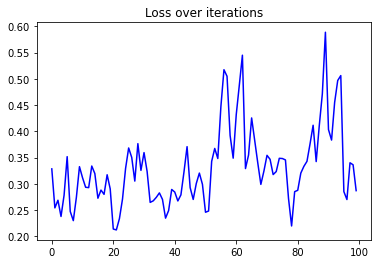

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

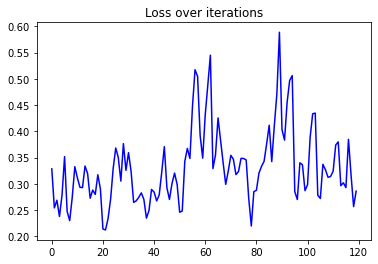

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 121 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 122 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 123 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 124 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 125 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 126 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 127 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 128 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 129 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 130 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 131 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 132 - b

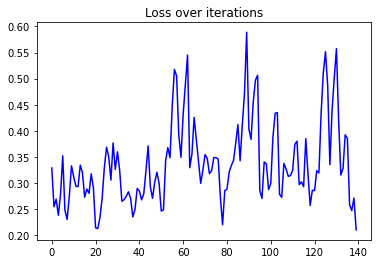

Peforming update on model with batch_size - 16
Iteration 140 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 141 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 142 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 143 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 144 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 145 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 146 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 147 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 148 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 149 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 150 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 151 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 152 - b

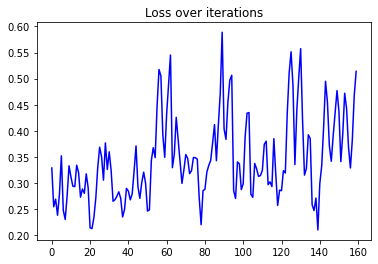

Peforming update on model with batch_size - 16
Iteration 160 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 161 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 162 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 163 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 164 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 165 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 166 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 167 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 168 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 169 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 170 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 171 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 172 - b

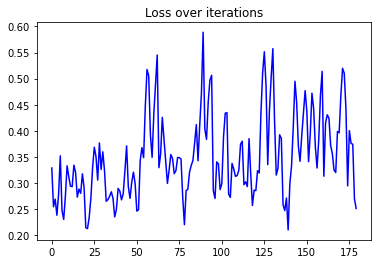

Peforming update on model with batch_size - 16
Iteration 180 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 181 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 182 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 183 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 184 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 185 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 186 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 187 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 188 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 189 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 190 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 191 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 192 - b

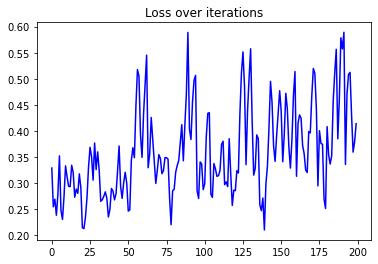

Peforming update on model with batch_size - 16
Iteration 200 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 201 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 202 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 203 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 204 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 205 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 206 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 207 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 208 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 209 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 210 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 211 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 212 - b

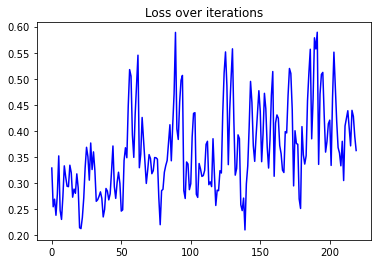

Peforming update on model with batch_size - 16
Iteration 220 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 221 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 222 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 223 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 224 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 225 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 226 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 227 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 228 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 229 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 230 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 231 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 232 - b

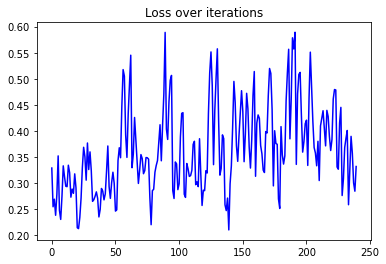

Peforming update on model with batch_size - 16
Iteration 240 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 241 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 242 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 243 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 244 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 245 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 246 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 247 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 248 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 249 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 250 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 251 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 252 - b

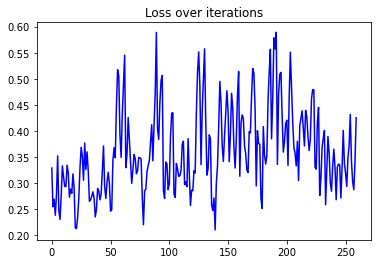

Peforming update on model with batch_size - 16
Iteration 260 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 261 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 262 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 263 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 264 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 265 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 266 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 267 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 268 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 269 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 270 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 271 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 272 - b

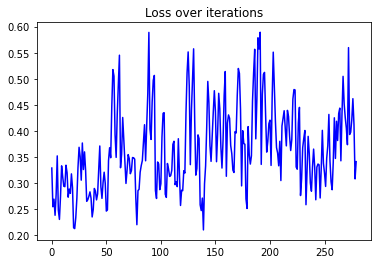

Peforming update on model with batch_size - 16
Iteration 280 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 281 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 282 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 283 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 284 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 285 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 286 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 287 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 288 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 289 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 290 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 291 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 292 - b

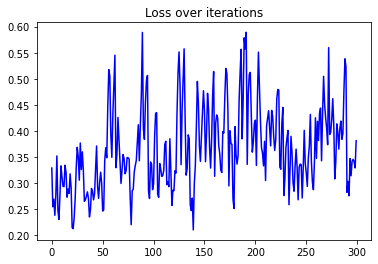

Peforming update on model with batch_size - 16
Iteration 300 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 301 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 302 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 303 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 304 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 305 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 306 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 307 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 308 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 309 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 310 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 311 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 312 - b

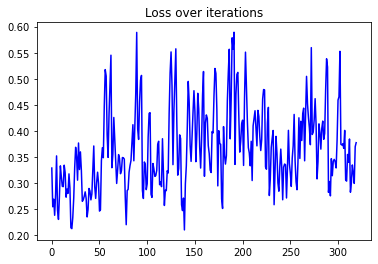

Peforming update on model with batch_size - 16
Iteration 320 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 321 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 322 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 323 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 324 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 325 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 326 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 327 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 328 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 329 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 330 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 331 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 332 - b

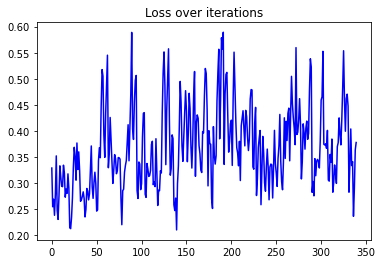

Peforming update on model with batch_size - 16
Iteration 340 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 341 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 342 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 343 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 344 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 345 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 346 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 347 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 348 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 349 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 350 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 351 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 352 - b

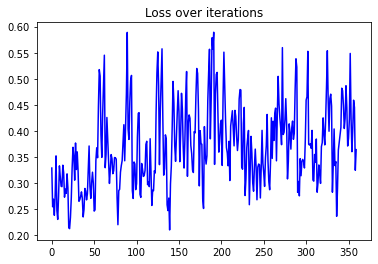

Peforming update on model with batch_size - 16
Iteration 360 - batch size: 16
Loss for epoch 0 - 0.3712445000532261


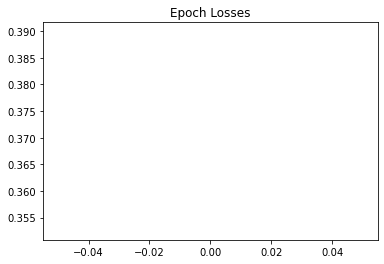

Entering epoch 1
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

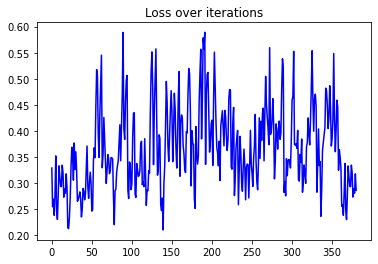

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

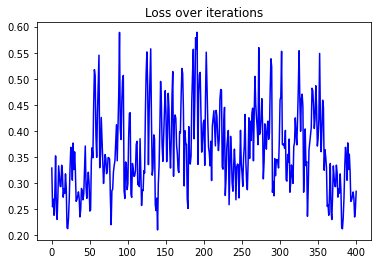

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

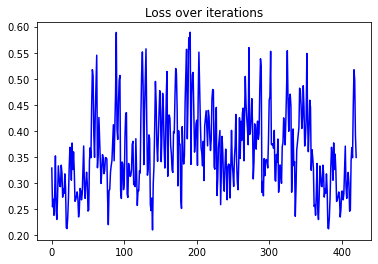

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

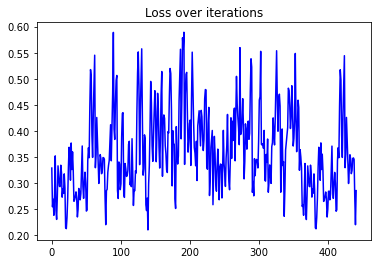

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

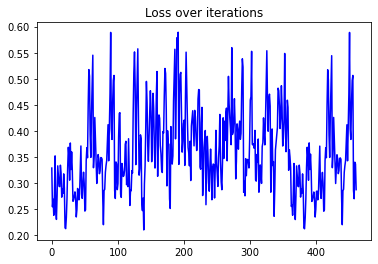

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

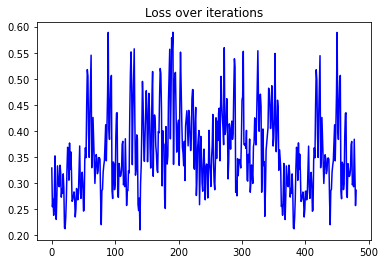

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 121 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 122 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 123 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 124 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 125 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 126 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 127 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 128 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 129 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 130 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 131 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 132 - b

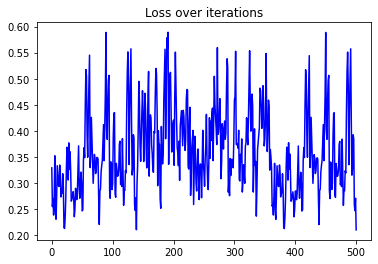

Peforming update on model with batch_size - 16
Iteration 140 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 141 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 142 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 143 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 144 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 145 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 146 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 147 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 148 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 149 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 150 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 151 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 152 - b

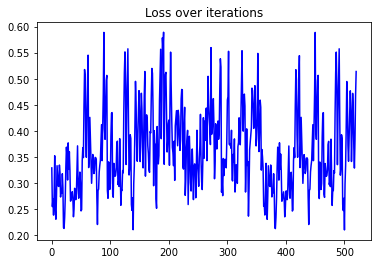

Peforming update on model with batch_size - 16
Iteration 160 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 161 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 162 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 163 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 164 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 165 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 166 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 167 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 168 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 169 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 170 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 171 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 172 - b

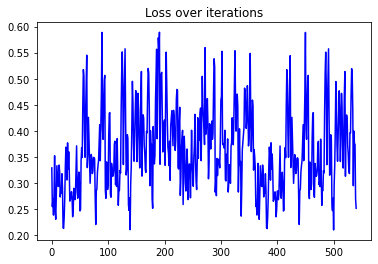

Peforming update on model with batch_size - 16
Iteration 180 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 181 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 182 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 183 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 184 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 185 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 186 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 187 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 188 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 189 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 190 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 191 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 192 - b

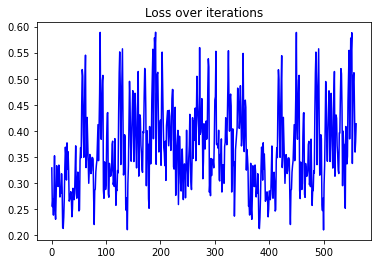

Peforming update on model with batch_size - 16
Iteration 200 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 201 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 202 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 203 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 204 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 205 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 206 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 207 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 208 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 209 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 210 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 211 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 212 - b

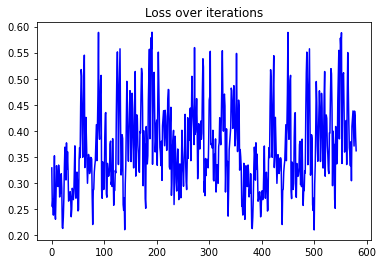

Peforming update on model with batch_size - 16
Iteration 220 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 221 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 222 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 223 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 224 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 225 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 226 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 227 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 228 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 229 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 230 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 231 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 232 - b

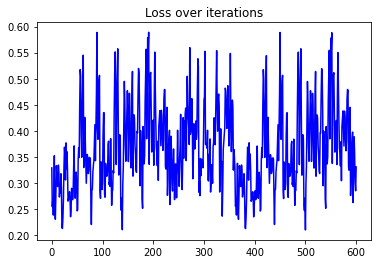

Peforming update on model with batch_size - 16
Iteration 240 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 241 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 242 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 243 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 244 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 245 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 246 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 247 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 248 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 249 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 250 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 251 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 252 - b

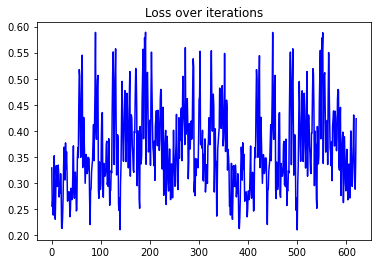

Peforming update on model with batch_size - 16
Iteration 260 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 261 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 262 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 263 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 264 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 265 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 266 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 267 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 268 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 269 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 270 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 271 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 272 - b

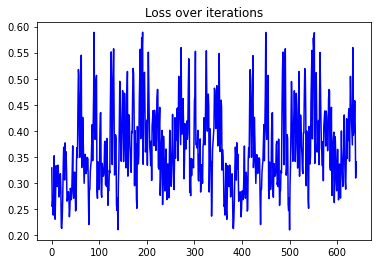

Peforming update on model with batch_size - 16
Iteration 280 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 281 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 282 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 283 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 284 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 285 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 286 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 287 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 288 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 289 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 290 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 291 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 292 - b

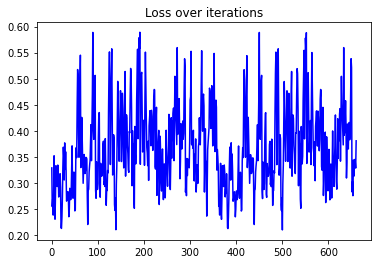

Peforming update on model with batch_size - 16
Iteration 300 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 301 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 302 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 303 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 304 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 305 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 306 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 307 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 308 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 309 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 310 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 311 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 312 - b

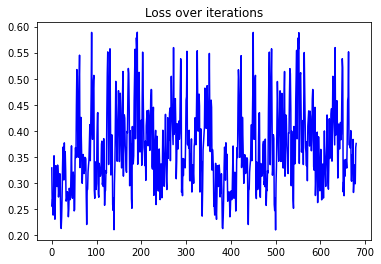

Peforming update on model with batch_size - 16
Iteration 320 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 321 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 322 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 323 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 324 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 325 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 326 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 327 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 328 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 329 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 330 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 331 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 332 - b

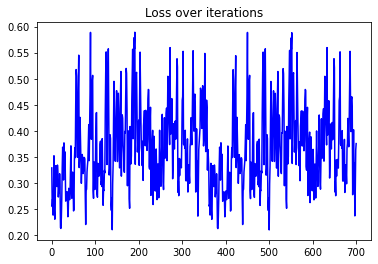

Peforming update on model with batch_size - 16
Iteration 340 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 341 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 342 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 343 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 344 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 345 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 346 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 347 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 348 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 349 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 350 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 351 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 352 - b

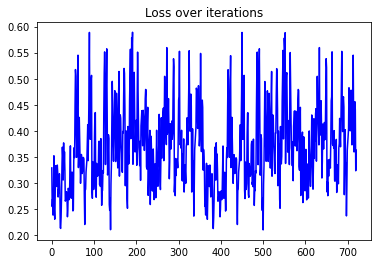

Peforming update on model with batch_size - 16
Iteration 360 - batch size: 16
Loss for epoch 1 - 0.37043095658690645


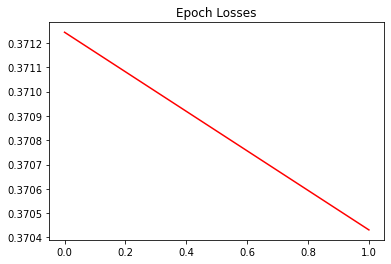

Entering epoch 2
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

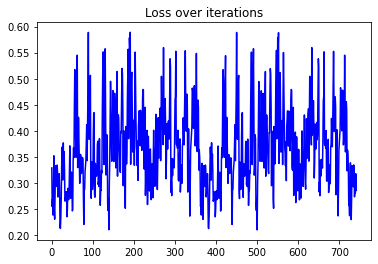

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

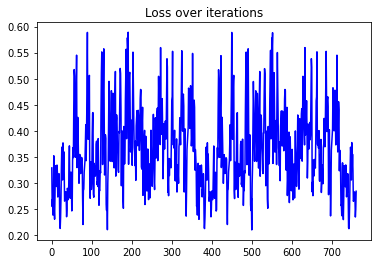

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

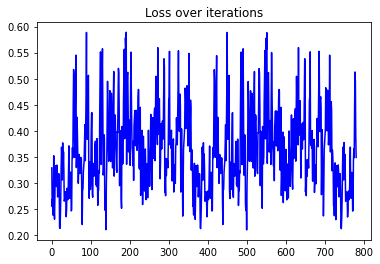

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

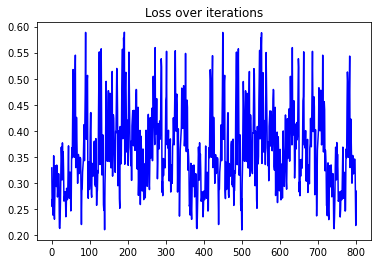

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

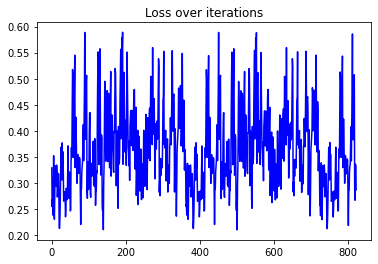

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

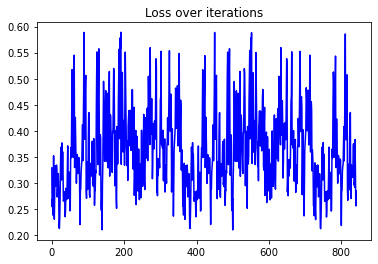

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 121 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 122 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 123 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 124 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 125 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 126 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 127 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 128 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 129 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 130 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 131 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 132 - b

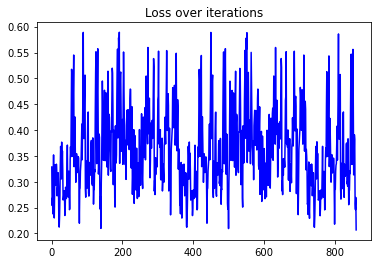

Peforming update on model with batch_size - 16
Iteration 140 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 141 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 142 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 143 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 144 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 145 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 146 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 147 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 148 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 149 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 150 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 151 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 152 - b

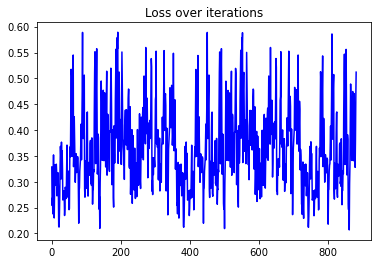

Peforming update on model with batch_size - 16
Iteration 160 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 161 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 162 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 163 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 164 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 165 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 166 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 167 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 168 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 169 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 170 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 171 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 172 - b

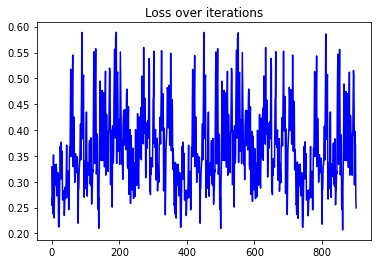

Peforming update on model with batch_size - 16
Iteration 180 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 181 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 182 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 183 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 184 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 185 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 186 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 187 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 188 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 189 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 190 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 191 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 192 - b

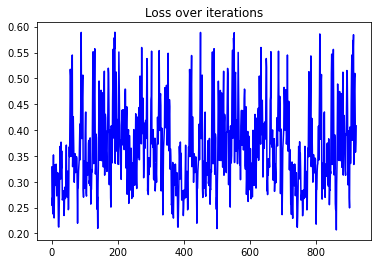

Peforming update on model with batch_size - 16
Iteration 200 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 201 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 202 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 203 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 204 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 205 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 206 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 207 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 208 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 209 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 210 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 211 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 212 - b

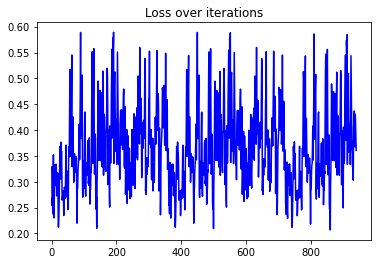

Peforming update on model with batch_size - 16
Iteration 220 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 221 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 222 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 223 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 224 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 225 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 226 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 227 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 228 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 229 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 230 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 231 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 232 - b

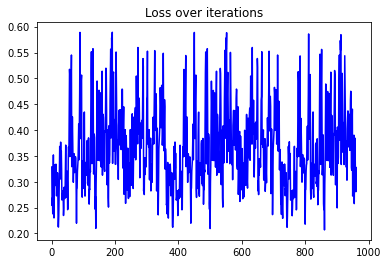

Peforming update on model with batch_size - 16
Iteration 240 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 241 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 242 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 243 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 244 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 245 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 246 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 247 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 248 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 249 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 250 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 251 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 252 - b

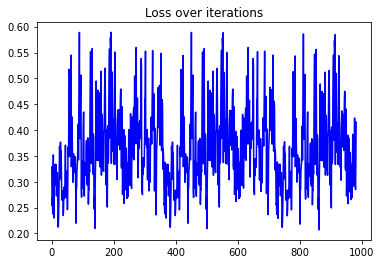

Peforming update on model with batch_size - 16
Iteration 260 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 261 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 262 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 263 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 264 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 265 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 266 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 267 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 268 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 269 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 270 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 271 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 272 - b

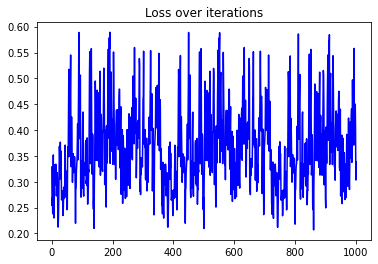

Peforming update on model with batch_size - 16
Iteration 280 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 281 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 282 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 283 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 284 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 285 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 286 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 287 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 288 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 289 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 290 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 291 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 292 - b

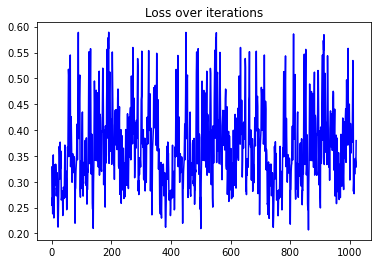

Peforming update on model with batch_size - 16
Iteration 300 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 301 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 302 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 303 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 304 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 305 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 306 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 307 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 308 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 309 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 310 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 311 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 312 - b

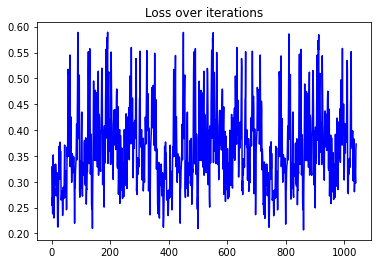

Peforming update on model with batch_size - 16
Iteration 320 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 321 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 322 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 323 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 324 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 325 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 326 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 327 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 328 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 329 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 330 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 331 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 332 - b

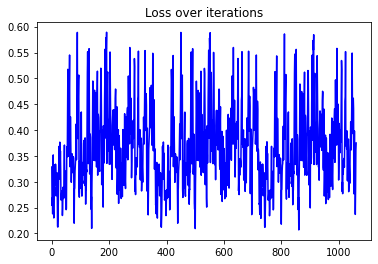

Peforming update on model with batch_size - 16
Iteration 340 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 341 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 342 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 343 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 344 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 345 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 346 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 347 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 348 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 349 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 350 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 351 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 352 - b

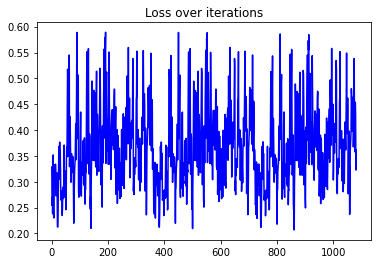

Peforming update on model with batch_size - 16
Iteration 360 - batch size: 16
Loss for epoch 2 - 0.36789593488555866


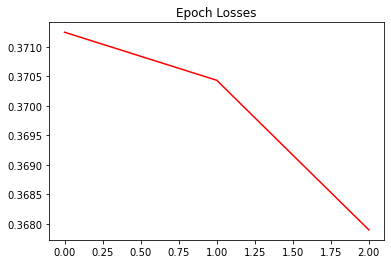

Entering epoch 3
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

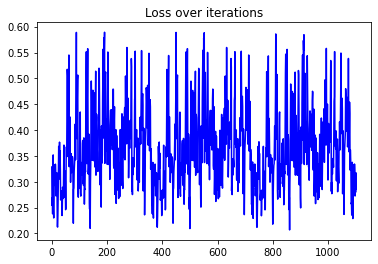

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

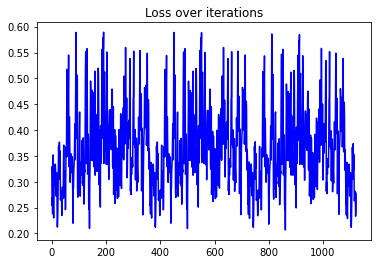

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

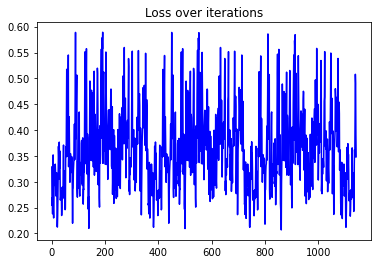

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

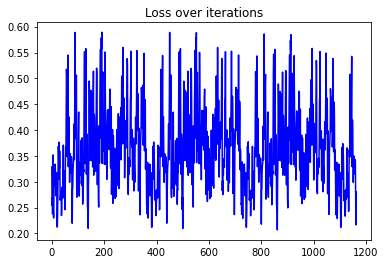

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

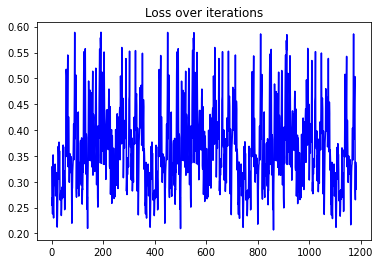

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

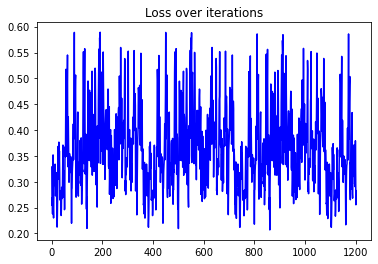

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 121 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 122 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 123 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 124 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 125 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 126 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 127 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 128 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 129 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 130 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 131 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 132 - b

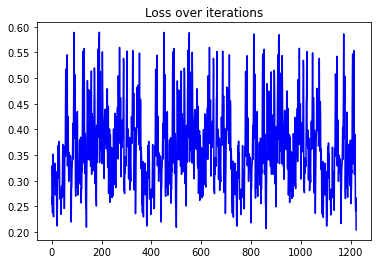

Peforming update on model with batch_size - 16
Iteration 140 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 141 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 142 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 143 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 144 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 145 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 146 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 147 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 148 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 149 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 150 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 151 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 152 - b

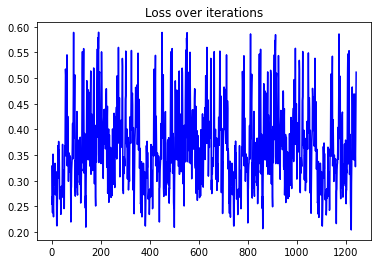

Peforming update on model with batch_size - 16
Iteration 160 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 161 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 162 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 163 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 164 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 165 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 166 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 167 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 168 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 169 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 170 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 171 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 172 - b

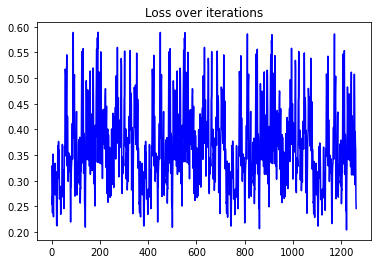

Peforming update on model with batch_size - 16
Iteration 180 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 181 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 182 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 183 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 184 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 185 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 186 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 187 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 188 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 189 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 190 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 191 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 192 - b

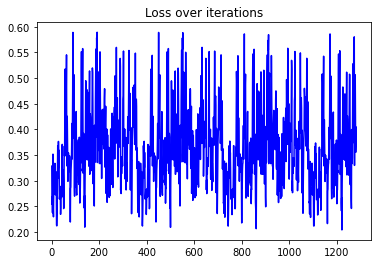

Peforming update on model with batch_size - 16
Iteration 200 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 201 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 202 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 203 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 204 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 205 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 206 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 207 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 208 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 209 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 210 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 211 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 212 - b

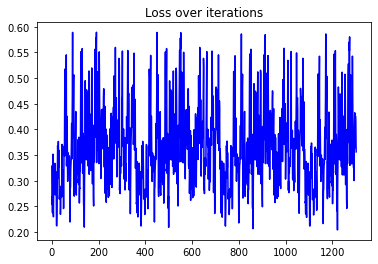

Peforming update on model with batch_size - 16
Iteration 220 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 221 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 222 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 223 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 224 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 225 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 226 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 227 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 228 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 229 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 230 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 231 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 232 - b

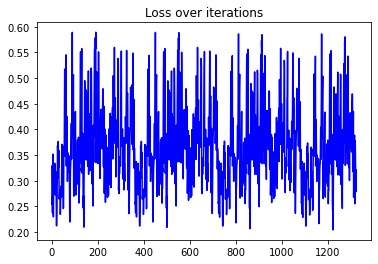

Peforming update on model with batch_size - 16
Iteration 240 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 241 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 242 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 243 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 244 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 245 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 246 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 247 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 248 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 249 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 250 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 251 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 252 - b

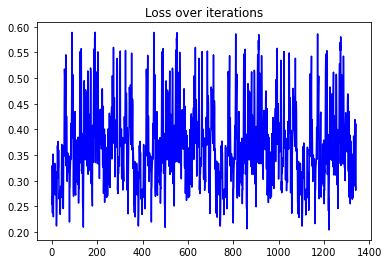

Peforming update on model with batch_size - 16
Iteration 260 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 261 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 262 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 263 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 264 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 265 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 266 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 267 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 268 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 269 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 270 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 271 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 272 - b

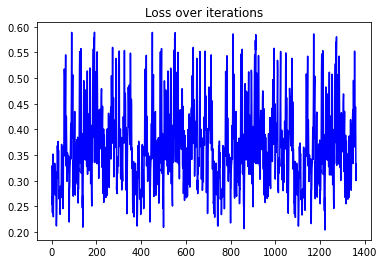

Peforming update on model with batch_size - 16
Iteration 280 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 281 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 282 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 283 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 284 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 285 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 286 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 287 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 288 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 289 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 290 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 291 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 292 - b

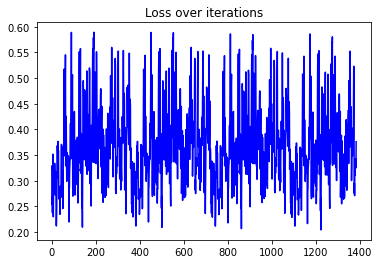

Peforming update on model with batch_size - 16
Iteration 300 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 301 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 302 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 303 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 304 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 305 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 306 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 307 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 308 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 309 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 310 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 311 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 312 - b

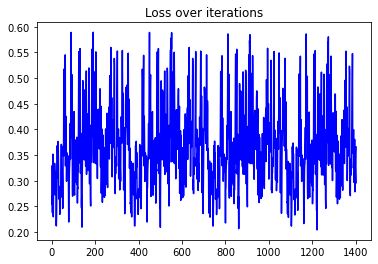

Peforming update on model with batch_size - 16
Iteration 320 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 321 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 322 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 323 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 324 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 325 - batch size: 16


In [ ]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

In [24]:
torch.save(model.encoder.state_dict(), os.path.join(dir_to_save, 'encoder_best'))
torch.save(model.decoder.state_dict(), os.path.join(dir_to_save, 'decoder_best'))

In [64]:
model.encoder.load_state_dict(torch.load('attnconv_ae/encoder_decoder_best/encoder_best', map_location=device))
model.decoder.load_state_dict(torch.load('attnconv_ae/encoder_decoder_best/decoder_best', map_location=device))

<All keys matched successfully>

#### Lets see the results


tensor(0.3556)
tensor(0.2776)
tensor(0.3914)
tensor(0.2330)
tensor(0.3336)
tensor(0.2350)
tensor(0.2830)
tensor(0.2223)
tensor(0.2628)
tensor(0.3852)


/opt/conda/envs/main-torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/opt/conda/envs/main-torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


tensor(0.2889)
tensor(0.1880)
tensor(0.2363)
tensor(0.2451)
tensor(0.2001)
tensor(0.2351)
tensor(0.3648)
tensor(0.2459)
tensor(0.2146)
tensor(0.2154)
tensor(0.2431)
tensor(0.2378)
tensor(0.2427)
tensor(0.1637)
tensor(0.4574)
tensor(0.7255)
tensor(0.3029)
tensor(0.1800)
tensor(0.2501)
tensor(0.2491)
tensor([ 954.1693, 1003.8665, 1019.8787, 1020.0015, 1019.4849, 1019.7358,
        1018.8287, 1019.2186, 1018.3771, 1018.9589, 1017.8934, 1018.5488,
        1017.5598, 1018.3674, 1017.0657, 1017.8756, 1016.8759, 1017.8489,
        1016.5422, 1017.5234, 1016.4982, 1017.6439, 1016.3790, 1017.4018,
        1016.2751, 1017.4964, 1016.1115, 1017.1902, 1016.0963, 1017.3663,
        1016.0589, 1017.1337, 1016.1069, 1017.3522, 1016.1310, 1017.1692,
        1016.1183, 1017.3651, 1016.0749, 1017.1749, 1016.1179, 1017.3826,
        1016.1210, 1017.1752, 1016.1142, 1017.3695, 1016.1142, 1017.1785,
        1016.0684, 1017.3486, 1015.9885, 1017.1282, 1015.9980, 1017.3239,
        1015.9705, 1017.0872, 1015

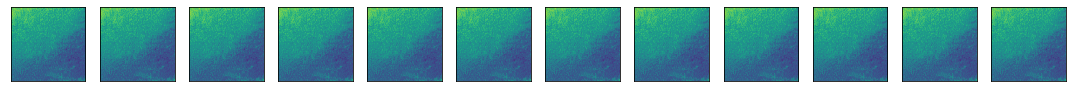

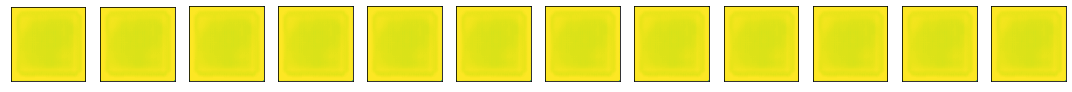

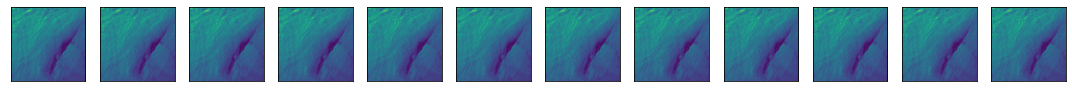

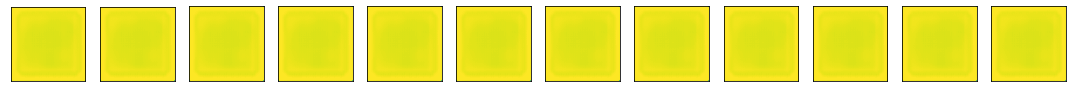

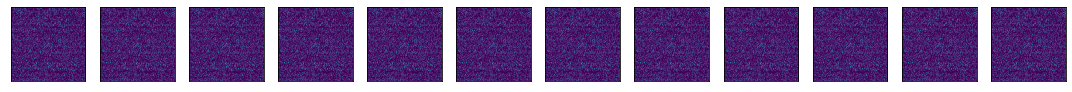

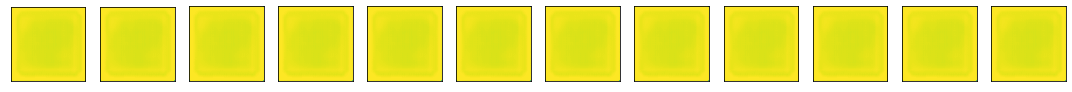

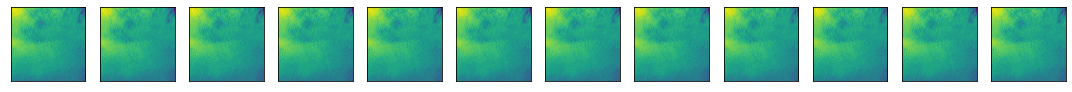

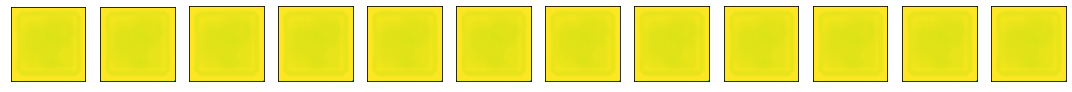

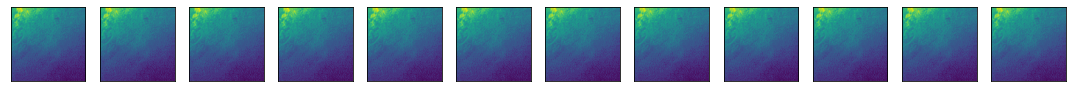

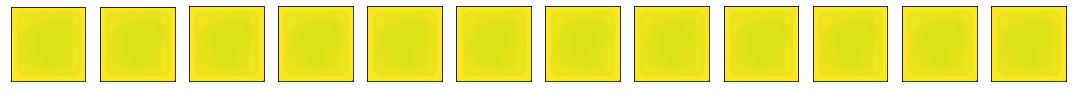

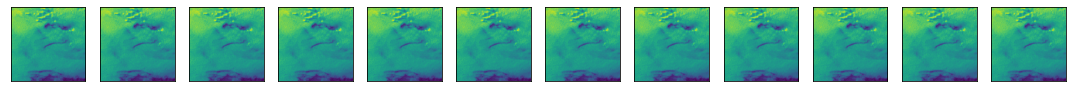

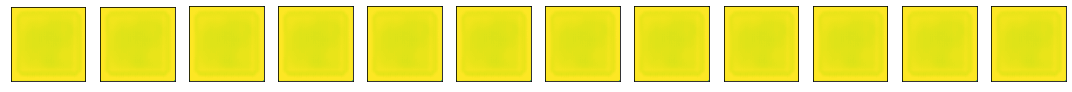

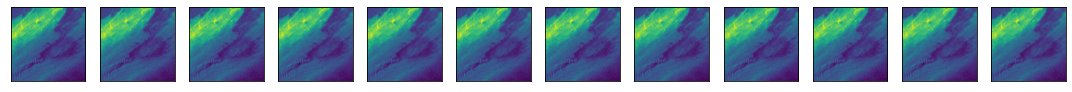

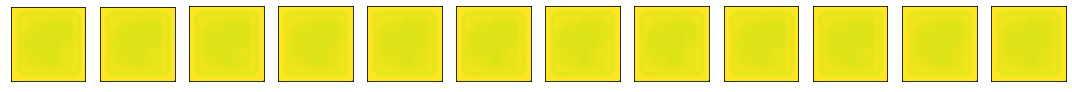

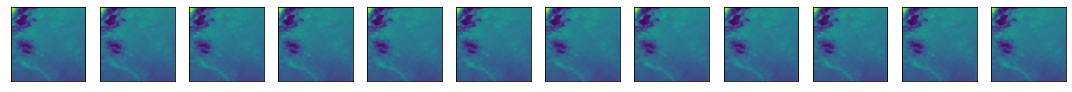

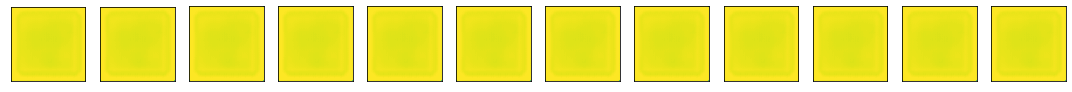

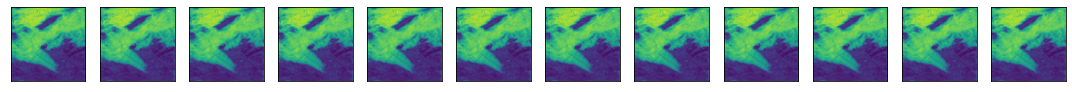

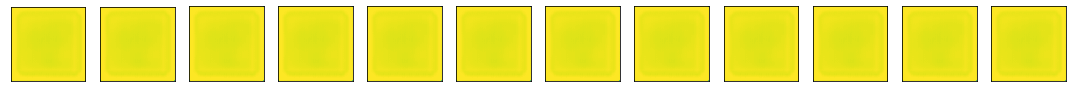

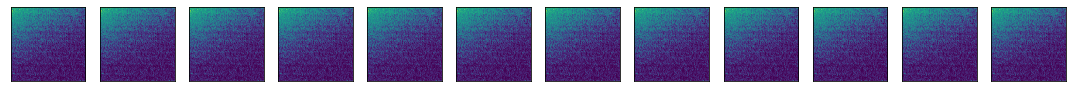

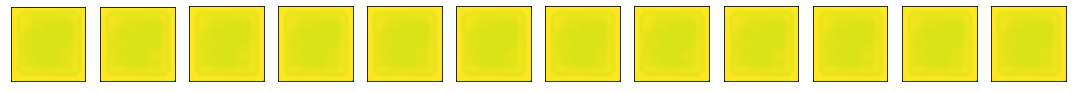

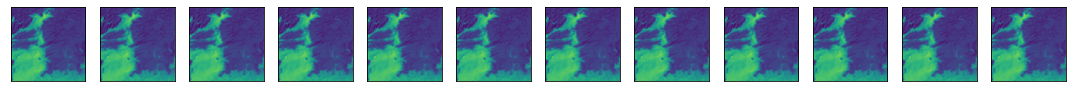

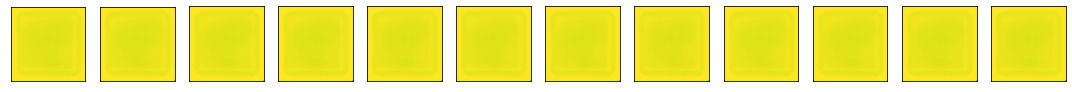

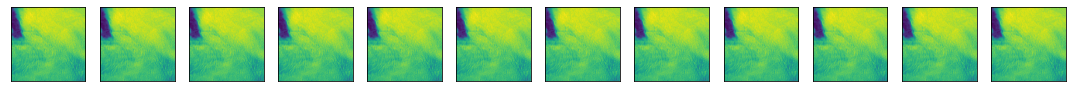

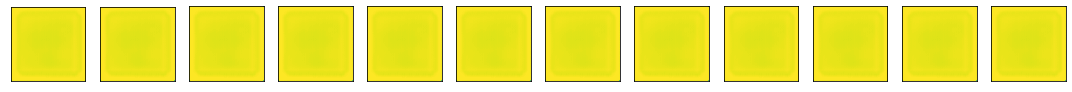

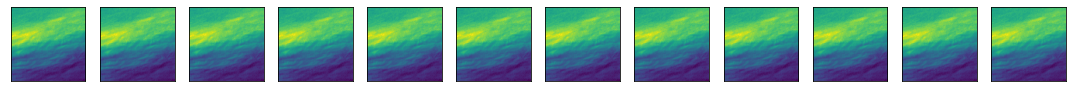

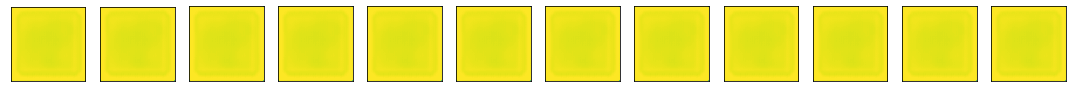

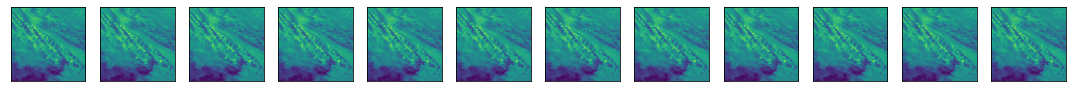

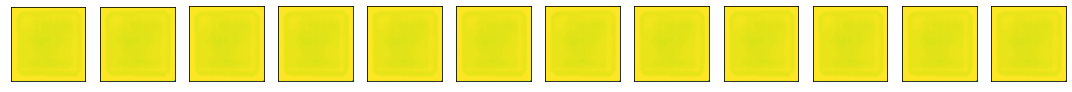

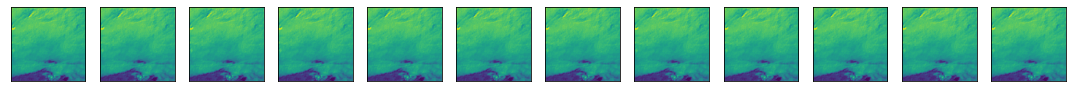

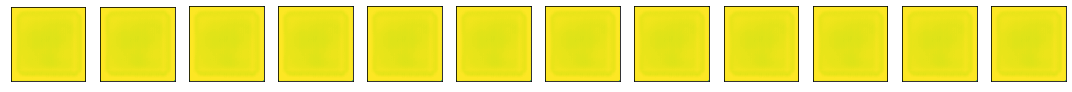

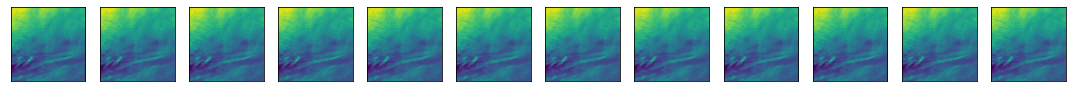

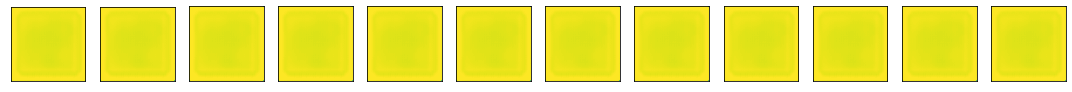

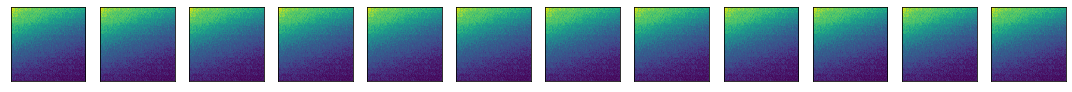

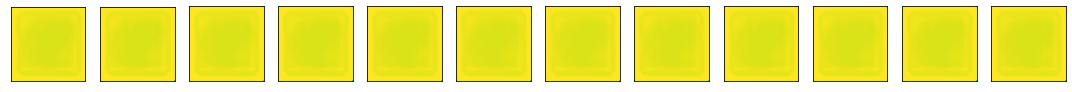

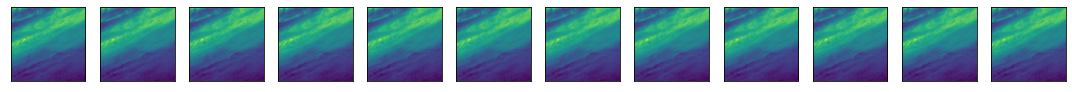

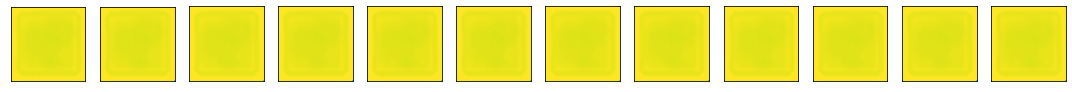

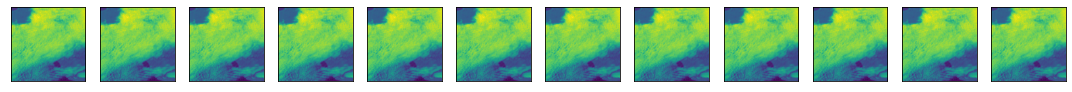

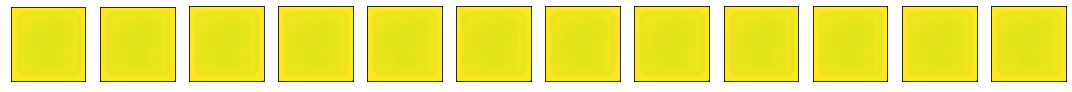

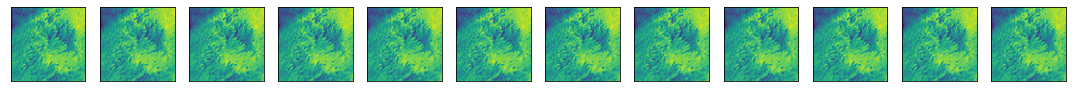

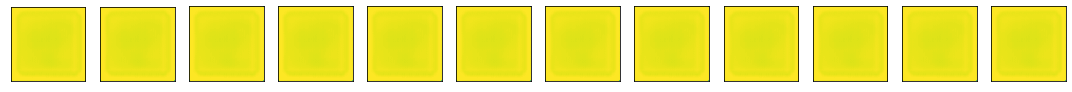

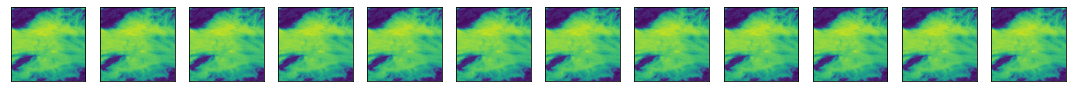

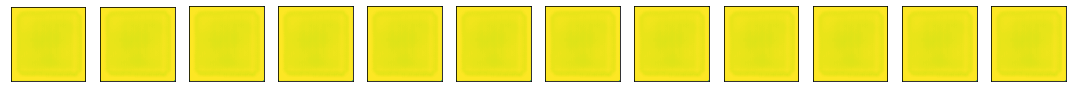

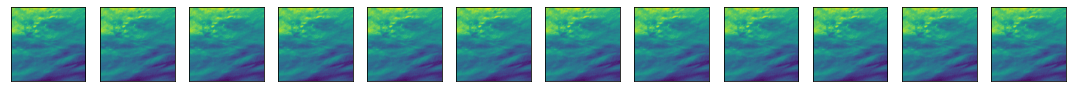

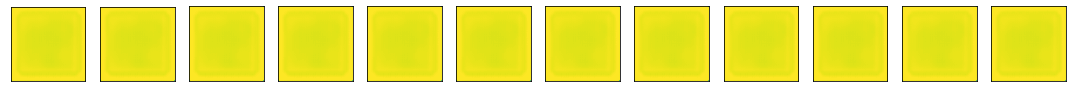

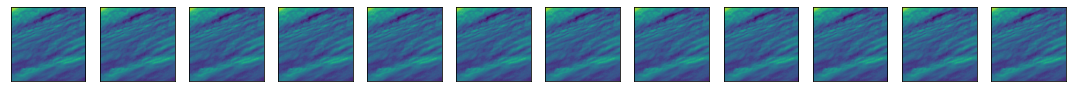

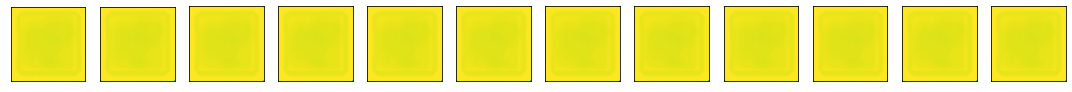

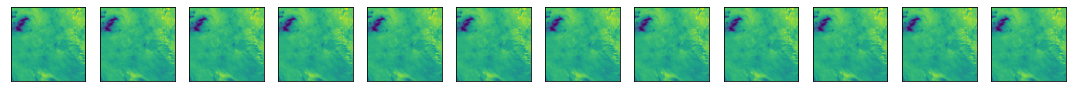

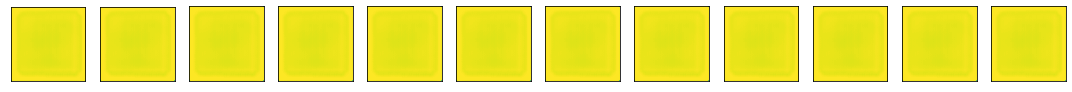

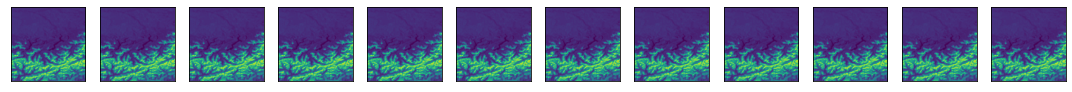

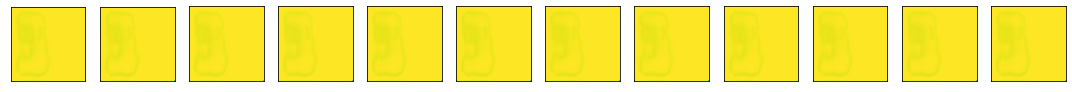

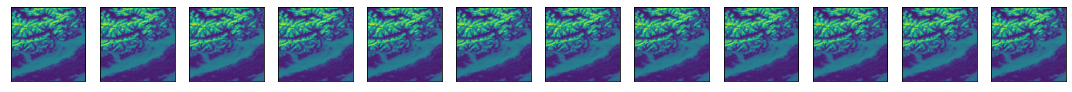

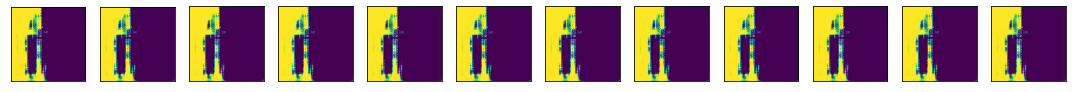

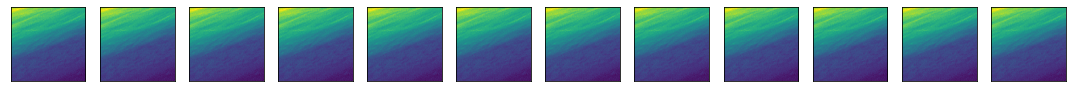

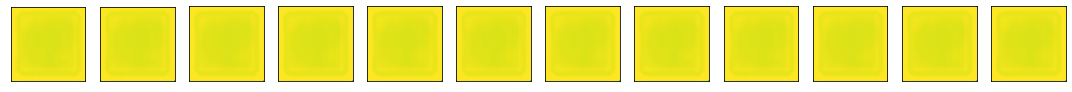

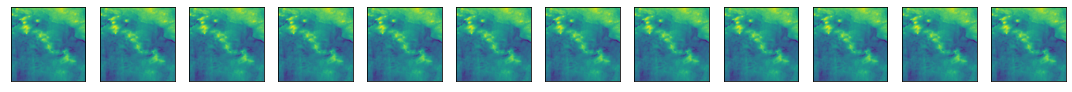

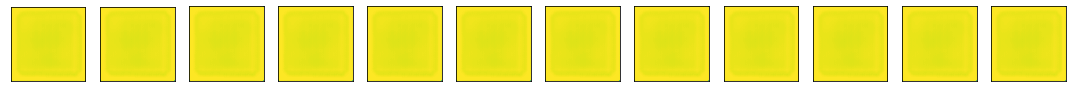

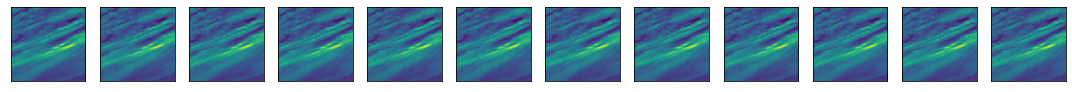

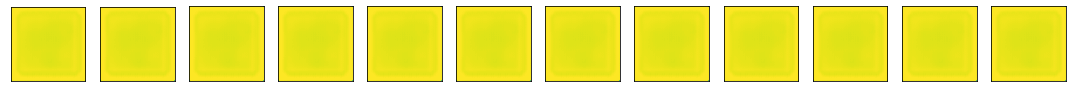

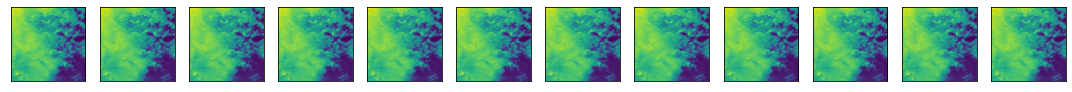

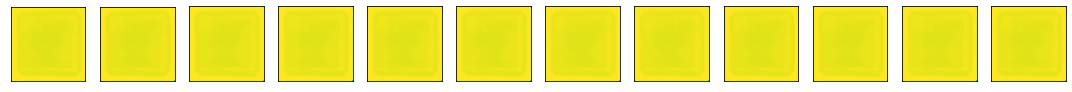

In [27]:
model.eval()
garbo = [dataset[i] for i in range(10, 40)]
for i, (features, targets) in enumerate(garbo):
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features, cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).view([-1, 1, 128, 128]).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(1, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for ax in axs:
        ax.imshow(predictions, cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        #print(predictions[p_no])
        p_no += 1
    fig.tight_layout()
    
    for feature in features:
#         print(predictions.shape, feature.shape)
        print(msssim(predictions.view([1,1,128,128]).type(torch.FloatTensor),feature.view([1,1,128,128]).type(torch.FloatTensor)))
    
    fig.show()
print(predictions[0])

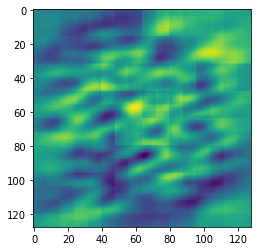

tensor(8.9988)
tensor(-0.9999)


In [62]:
latent = torch.rand([1, 4096, 1, 1]) * 10 - 1
garbage = model.decoder(latent)
plt.imshow(garbage.detach().squeeze(), cmap='viridis')
plt.show()
print(torch.max(latent))
print(torch.min(latent))

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()